In [1]:
import torch
import cuda
device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")
# device: 'cpu'

print(torch.cuda.is_available())
# false

torch.cuda.get_device_name(0)
# RuntimeError: CUDA driver initialization failed, you might not have a CUDA GPU.

torch.cuda.current_device()
# RuntimeError: CUDA driver initialization failed, you might not have a CUDA GPU.

ModuleNotFoundError: No module named 'torch'

In [2]:
import tensorflow as tf

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

c:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
from preprocess import shortenDataset
import os
import configparser
import utils 
import importlib
importlib.reload(utils)

params = configparser.ConfigParser()
params._interpolation = configparser.ExtendedInterpolation()
params.read('./config.ini')

print(utils.configWandB(params['HYPERPARAMETERS']))

# shortenDataset(os.path.abspath(params["DIRECTORIES"]["train"]), os.path.abspath(params["DIRECTORIES"]["train_short"]) + '/train_dataset.csv')
# shortenDataset(os.path.abspath(params["DIRECTORIES"]["validation"]), os.path.abspath(params["DIRECTORIES"]["validation_short"]) + '/eval_dataset.csv')
# print("")

{'node_state_dim': 128, 't': 8, 'readout_units': 256, 'decay_steps': 30, 'window': 200, 'batch_size': 16, 'epochs': 100, 'classes': 15, 'decay_rate': 0.6, 'learning_rate': 0.001}


In [7]:
# x axis values
epochs = []
# corresponding y axis values
accuracy = []
loss = []
class_precision = []
class_recall = []
class_accuracy = []
f1_weighted = []
f1_macro = []
class_f1 = []
lr = []

In [8]:
def calculateF1(precision, recall):
    return [2*(p*r)/(p+r) for (p, r) in zip(precision, recall)]

In [9]:
import glob
import torch
path = "./logs/ckpt"

allFiles = glob.glob(path + '/*.pt')

startingEpoch = 0

files = [(path, path.split('\\')[-1]) for path in allFiles]
files = [(path, '.'.join(el.split('.')[1:-1])) for (path, el) in files]
files = [(path, el.split('-')) for (path, el) in files]
files = [(path, {'Epoch': int(el[0]), 'Loss': float(el[1])}) for (path, el) in files]
files = [x for x in files if x[1]['Epoch'] > startingEpoch]
files.sort(key=lambda x: (x[1]['Epoch'], x[1]['Loss']), reverse=False)

for file in files:    
    filepath = file[0]

    checkpoint = torch.load(filepath)
    accuracy.append(checkpoint['accuracy'])
    loss.append(checkpoint['loss'])
    epochs.append(checkpoint['epoch'])
    class_recall.append(checkpoint['class_recall'])
    class_precision.append(checkpoint['class_precision'])
    class_accuracy.append(checkpoint['class_accuracy'])
    f1_weighted.append(checkpoint['f1_weighted'])
    f1_macro.append(checkpoint['f1_macro'])
    class_f1.append(calculateF1(checkpoint['class_precision'], checkpoint['class_recall']))
    lr.append(checkpoint['lr'])


C:\Users\PC-312\AppData\Local\Temp/ipykernel_3324/2722848388.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return [2*(p*r)/(p+r) for (p, r) in zip(precision, recall)]


In [10]:
# importing the required modules
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

def plotGeneralMetric(loss, metrics, metricLabels, title=""):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(loss, color='gray', label="Loss")
    ax.tick_params(axis='y', labelcolor='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.48))

    ax2 = ax.twinx()
    color = cm.rainbow(np.linspace(0, 1, len(metrics)))   
    for i in range(len(metrics)):
        ax2.plot(metrics[i], color=color[i], label=metricLabels[i])
        ax2.tick_params(axis='y', labelcolor="green")
    
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.55))
    plt.show()

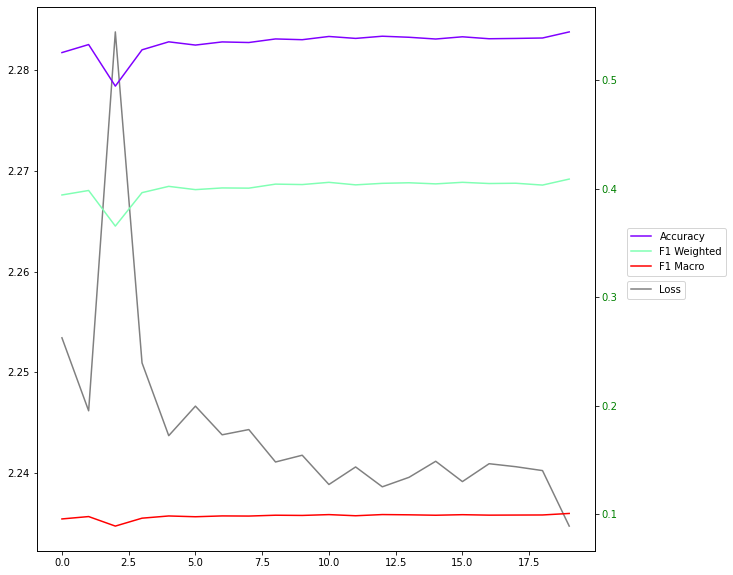

In [11]:
plotGeneralMetric(loss, [accuracy, f1_weighted, f1_macro], ["Accuracy", "F1 Weighted", "F1 Macro"])

In [12]:

from generator import attack_names
import numpy as np
def plotMetricByAttack(plot, metric, title=""):
    linestyle = ['solid' , 'dashed' , 'dashdot' , 'dotted']
    color = cm.rainbow(np.linspace(0, 1, 15))
    plot.set_title(title, fontdict={'fontsize': 25})
    for i, c in zip(range(15), color):
        loopMetric = [el[i] for el in metric]
        plot.plot(epochs, loopMetric, color=c, label= ("" if np.max(loopMetric) > 0.05 else "(HID)") + attack_names[i], linestyle=linestyle[i % len(linestyle)])

    plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

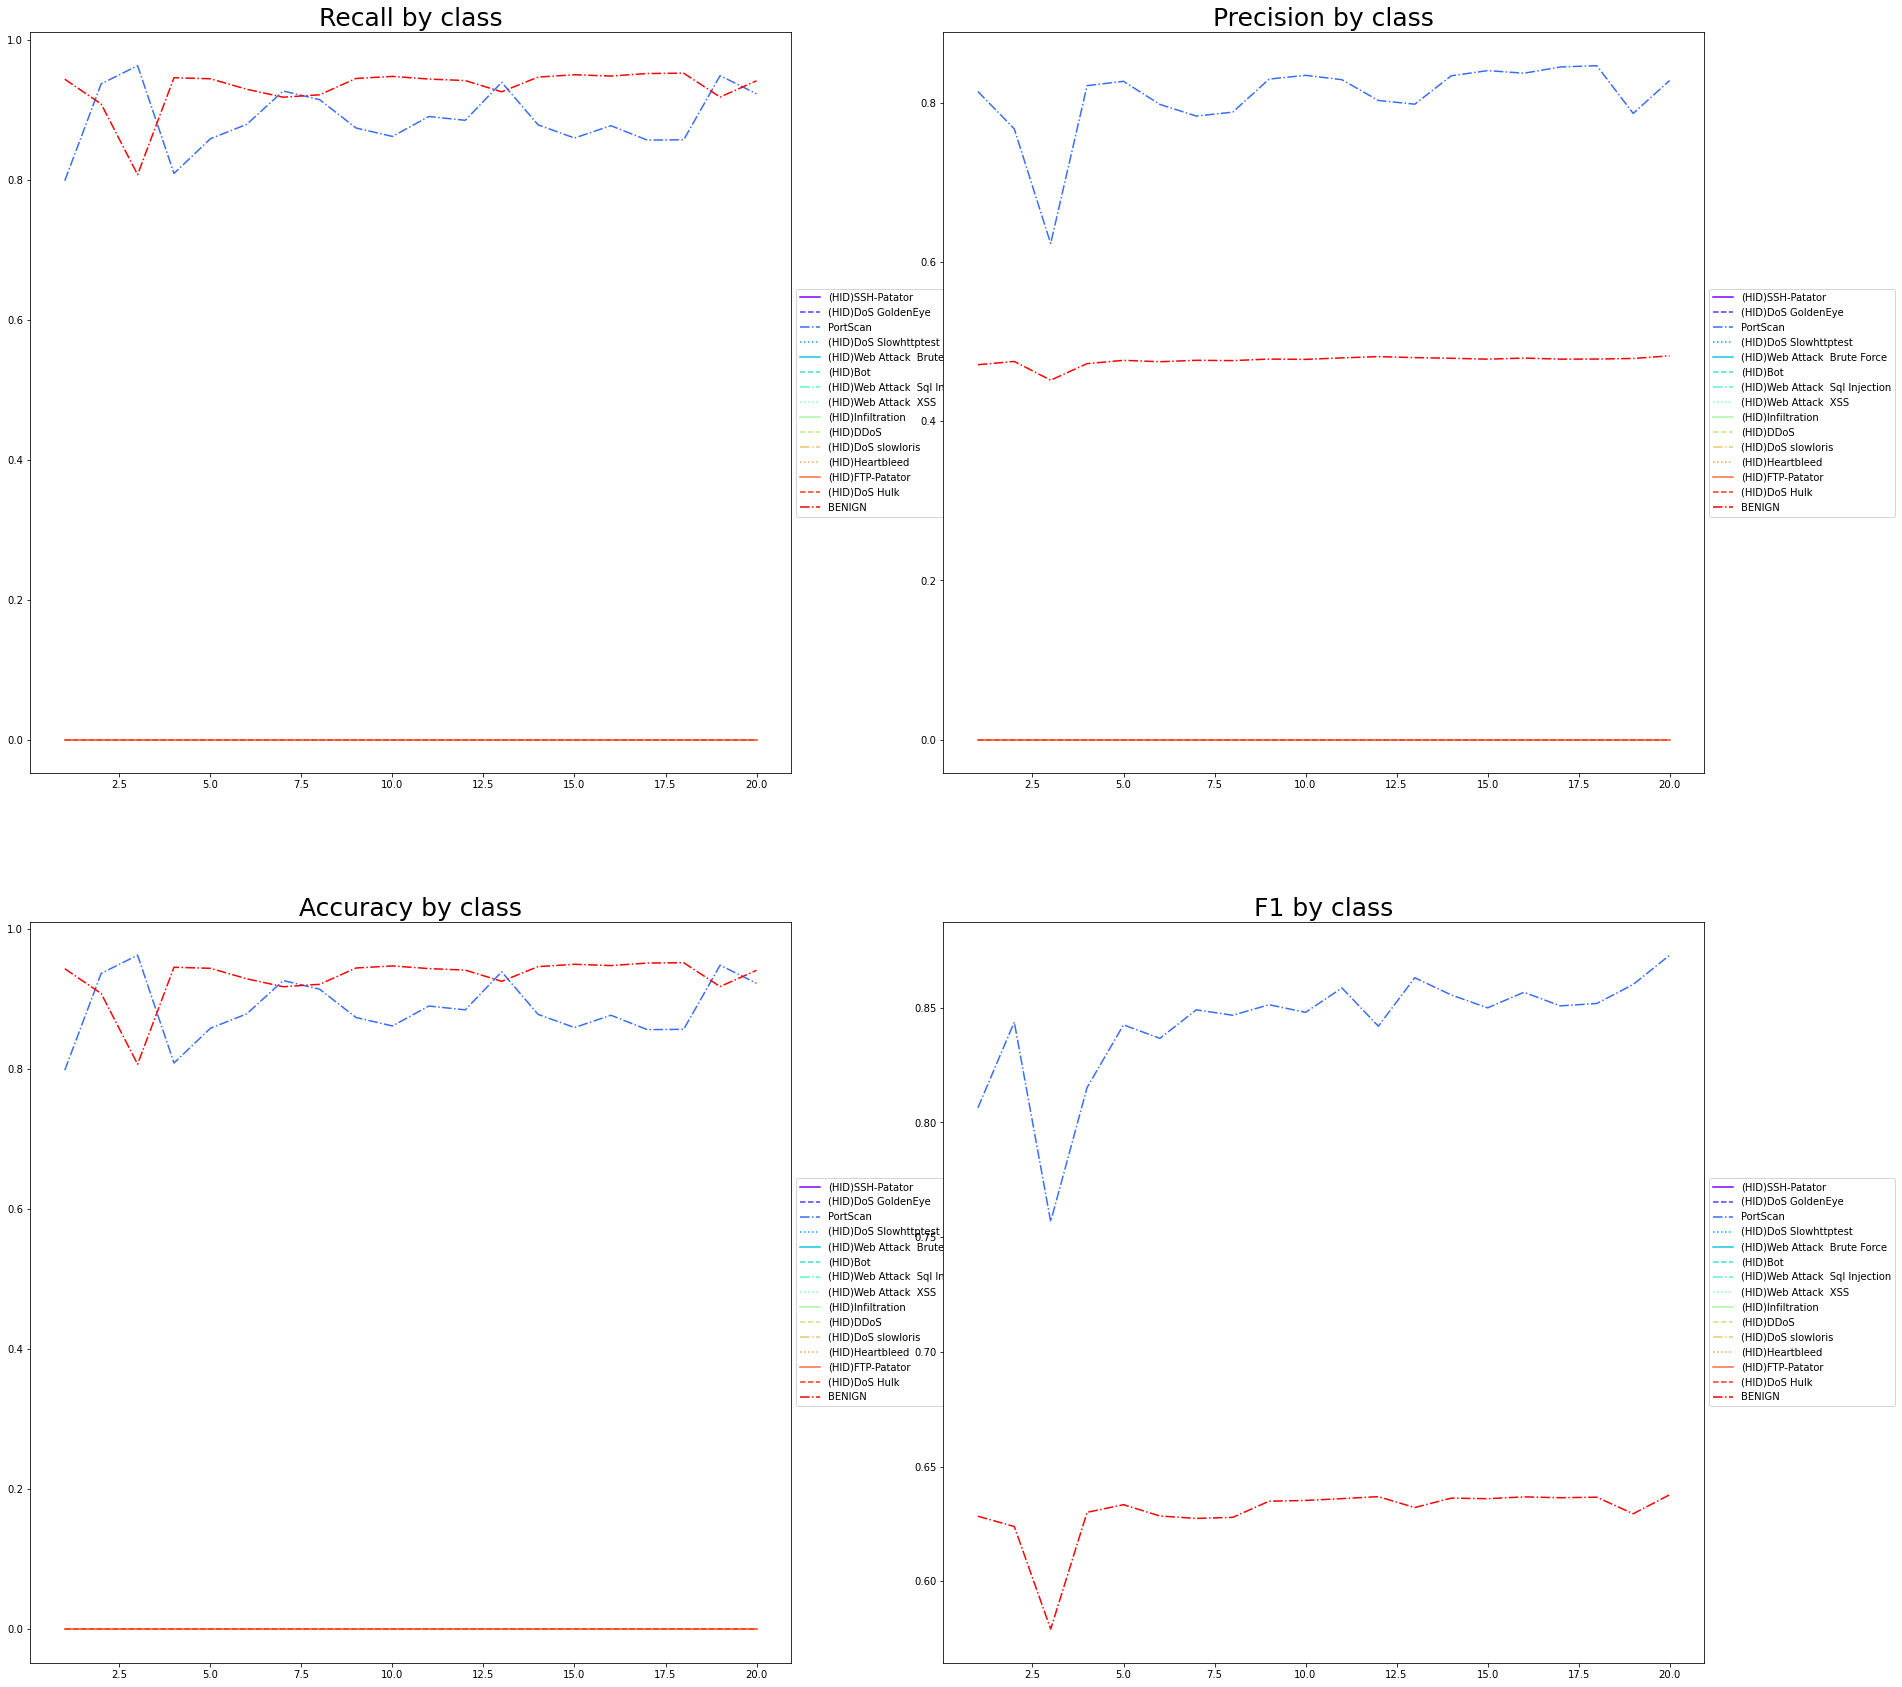

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.set_size_inches(30, 30)
plotMetricByAttack(ax1, class_recall, title="Recall by class")
plotMetricByAttack(ax2, class_precision, title="Precision by class")
plotMetricByAttack(ax3, class_accuracy, title="Accuracy by class")
plotMetricByAttack(ax4, class_f1, title="F1 by class")

# ax4.set_visible(False)

# ax1.legend(loc='center left', bbox_to_anchor=(1.15, -0.4), prop={'size': 20} )

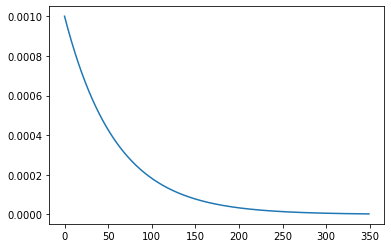

In [14]:
from GNN import GNN
import matplotlib.pyplot as plt

def temp(epoch, lr: float, dr: float, ds: int):
    """This is an Exponential decay calculation (equivalent to Tensorflow's tf.keras.optimizers.schedules.ExponentialDecay)"""
    return lr * dr ** (epoch / ds)
    

values = [temp(i, 0.001, 0.6, 30) for i in range(350)]

plt.plot(values)


In [15]:
values[349]

2.6251827758226957e-06